# Toxicity Target Type Classification

In this notebook, we will train a baseline model to predict the type of a targeted toxic comment.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import logging
import numpy as np
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda import is_available
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from simpletransformers.classification import (
    ClassificationModel,
    ClassificationArgs
)

from src.modeling.utils import (
    download_dataset,
    get_dataset_version,
    prep_data,
    clean_simpletransformers
)

%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 6,
    "test_size": 0.3,
    "use_cuda": is_available()
}

In [ ]:
experiment_name = "toxicity-target-type-classification"

mlflow.set_experiment(experiment_name)

mlflow.start_run(tags={"project": "olid-br"})

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [4]:
df = download_dataset()

mlflow.log_param("dataset_version", f"v{get_dataset_version()}")

print(f"Shape: {df.shape}")
df.head()

Shape: (4676, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


We need to filter only targeted toxic comments.

In [5]:
df = df[(df["is_offensive"] == "OFF") & (df["is_targeted"] == "TIN") & (df["targeted_type"].notnull())]
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape}")

Shape: (2668, 17)


## Exploratory Data Analysis (EDA)

In the next section, we will perform some exploratory data analysis (EDA) to understand the data.

In [6]:
df_eda = df[["text", "targeted_type"]].groupby("targeted_type").count()
df_eda.reset_index(inplace=True)
df_eda

,targeted_type,text
0,GRP,763
1,IND,1717
2,OTH,188


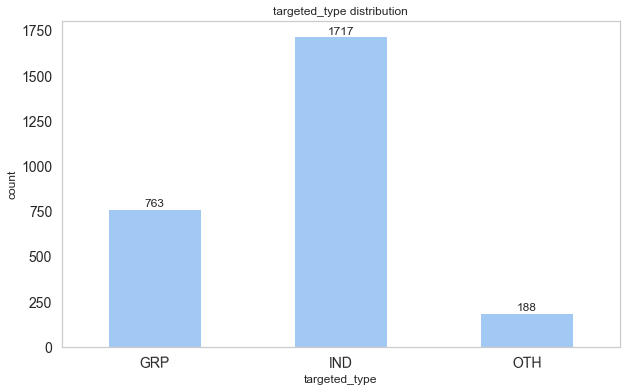

In [7]:
ax = df_eda.plot(x="targeted_type", y="text", kind="bar",
                 legend=False, figsize=(10, 6), grid=False,
                 xlabel="targeted_type", ylabel="count", fontsize=14,
                 rot=1, title="targeted_type distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=12)

mlflow.log_figure(
    figure=ax.get_figure(),
    artifact_file="targeted_type_distribution.png")

In [ ]:
classes = {
    0: "IND",
    1: "GRP",
    2: "OTH"
}

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [ ]:
X = df["text"].values
y = df["targeted_type"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params["test_size"],
                                                    random_state=params["seed"],
                                                    stratify=y)

train_data = prep_data(X_train, y_train, classes)
test_data = prep_data(X_test, y_test, classes)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

mlflow.log_param("train_size", len(df_train))
mlflow.log_param("test_size", len(df_test))

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")

## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [ ]:
clean_simpletransformers()
        
# Compute class weights
params["class_weights"] = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train).tolist()

# Optional model configuration
model_args = ClassificationArgs(
    num_train_epochs=params["num_train_epochs"])

mlflow.log_params(model_args.__dict__)

# Create a ClassificationModel
model = ClassificationModel(
    model_type=params["model_type"],
    model_name=params["model_name"],
    num_labels=len(np.unique(y_train)),
    args=model_args,
    weight=params["class_weights"],
    use_cuda=params["use_cuda"]
)

# Train the model
model.train_model(df_train)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;
- **ROC AUC**: the area under the receiver operating characteristic Curve (ROC AUC).

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

In [ ]:
# Logging metrics in MLflow
metrics = classification_report(
    y_true, y_pred, digits=4,
    target_names=classes.values(), output_dict=True)

mlflow.log_metric("mcc", result["mcc"])
mlflow.log_metric("accuracy", metrics["accuracy"])
mlflow.log_metric("weighted_f1_score", metrics["weighted avg"]["f1-score"])
mlflow.log_metric("weighted_precision", metrics["weighted avg"]["precision"])
mlflow.log_metric("weighted_recall", metrics["weighted avg"]["recall"])

mlflow.log_metric("IND_precision", metrics["IND"]["precision"])
mlflow.log_metric("IND_recall", metrics["IND"]["recall"])
mlflow.log_metric("IND_f1_score", metrics["IND"]["f1-score"])
mlflow.log_metric("GRP_precision", metrics["GRP"]["precision"])
mlflow.log_metric("GRP_recall", metrics["GRP"]["recall"])
mlflow.log_metric("GRP_f1_score", metrics["GRP"]["f1-score"])
mlflow.log_metric("OTH_precision", metrics["OTH"]["precision"])
mlflow.log_metric("OTH_recall", metrics["OTH"]["recall"])
mlflow.log_metric("OTH_f1_score", metrics["OTH"]["f1-score"])

# Classification report file
mlflow.log_text(
    text=classification_report(
        y_true, y_pred, digits=4,
        target_names=["IND", "GRP", "OTH"]),
    artifact_file="classification_report.txt")

## Testing the model

In the last section, we will test the model with some comments from the test set.

In [ ]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred.to_csv("pred.csv", index=False, encoding="utf-8")
mlflow.log_artifact("pred.csv")

df_pred

## Register model in MLflow

In this section, we will register the model in MLflow.

In [ ]:
def get_conda_env():
    import torch
    from mlflow.utils.environment import _mlflow_conda_env

    conda_env = _mlflow_conda_env(
        additional_conda_deps=[
            f"pytorch={torch.__version__}",
            "simpletransformers==0.63.7"
        ]
    )

    return conda_env

mlflow.pytorch.log_model(
    pytorch_model=model.model,
    conda_env=get_conda_env(),
    artifact_path="model",
    registered_model_name=experiment_name)

In [ ]:
clean_simpletransformers()

mlflow.end_run()